## 1. Setup

In [1]:
import sys
sys.path.append('..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os

from unet import unet
from utils.dataset_utils import load_dataset_split, save_images, load_results
from utils.preprocessing import merge_patches_directly_and_save_all
from utils.preprocessing import merge_patches_from_dir_and_save_all
from utils.vis_utils import plot_image_mask_prediction

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### 1.1 Parameters of the experiment (and hyperparameters from ../config.py)

In [4]:
UNET_NAME = config.UNET_NAME
EXPERIMENT_NAME = config.EXPERIMENT_NAME
DATASET_PATH = f'../datasets/{config.DATASET_NAME}'
UNSEEN_CATEGORIES_PATH = f'../datasets/unseen_categories'

In [5]:
CHECKPOINTS_PATH = f'../checkpoints'
CHECKPOINT_FILENAME = f'{CHECKPOINTS_PATH}/{EXPERIMENT_NAME}/{UNET_NAME}.hdf5'
LOGS_PATH = f'../logs'
LOGS_FILENAME = f'{LOGS_PATH}/{EXPERIMENT_NAME}.json'
RESULTS_PATH = f'../results/{EXPERIMENT_NAME}'

In [6]:
print(EXPERIMENT_NAME)

inria_aerial/subset_chicago/UNet_RGB


## 2. Load the dataset splits

In [7]:
train_images, train_masks, train_img_names = load_dataset_split(DATASET_PATH, 'train')
val_images, val_masks, val_img_names = load_dataset_split(DATASET_PATH, 'val')
test_images, test_masks, test_img_names = load_dataset_split(DATASET_PATH, 'test')

train_masks = train_masks[..., np.newaxis]
val_masks = val_masks[..., np.newaxis]
test_masks = test_masks[..., np.newaxis]

print(train_images.shape, train_images.dtype, train_images.min(), train_images.max())
print(val_images.shape, val_images.dtype, val_images.min(), val_images.max())
print(val_img_names[:3])

(200, 512, 512, 3) float64 0.0 1.0
(100, 512, 512, 3) float64 0.0 1.0
['chicago12_5000_5000_0_0.png', 'chicago12_5000_5000_0_1.png', 'chicago12_5000_5000_0_2.png']


### 2.1 Load UNSEEN_CATEGORIES images

In [8]:
unseen_cat = load_dataset_split(UNSEEN_CATEGORIES_PATH, 'test', with_masks=False)
unseen_cat_images, _, unseen_cat_img_names = unseen_cat

print(unseen_cat_images.shape, unseen_cat_images.dtype,
      unseen_cat_images.min(), unseen_cat_images.max())

(6, 512, 512, 3) float64 0.0 1.0


## 3. Make some predictions with the best model

### Remember:
1. we used patches (not initial images) for the training part;
2. accuracy is not a good metric for image segmentation evaluation (patches with small objects can have good accuracies with zero prediction for all pixels).

### 3.1 Load the best_model

In [9]:
best_model = unet(input_shape=config.INPUT_SHAPE,
                  pretrained_weights=CHECKPOINT_FILENAME)

### 3.2 Predict

In [10]:
%%time
train_preds = best_model.predict(train_images, batch_size=config.BATCH_SIZE).squeeze()
val_preds = best_model.predict(val_images, batch_size=config.BATCH_SIZE).squeeze()
test_preds = best_model.predict(test_images, batch_size=config.BATCH_SIZE).squeeze()
unseen_cat_preds = best_model.predict(unseen_cat_images, batch_size=config.BATCH_SIZE).squeeze()

CPU times: user 1min 41s, sys: 20.2 s, total: 2min 2s
Wall time: 1min 50s


In [11]:
print(test_preds.shape, test_preds.dtype, test_preds.min(), test_preds.max())
print(train_img_names[:3])
print(val_img_names[:3])
print(test_img_names[:3])

(100, 512, 512) float32 2.6879166e-10 0.9999045
['chicago10_5000_5000_0_0.png', 'chicago10_5000_5000_0_1.png', 'chicago10_5000_5000_0_2.png']
['chicago12_5000_5000_0_0.png', 'chicago12_5000_5000_0_1.png', 'chicago12_5000_5000_0_2.png']
['chicago24_5000_5000_0_0.png', 'chicago24_5000_5000_0_1.png', 'chicago24_5000_5000_0_2.png']


### 3.3 Save all predictions (patches, not initial images)

In [12]:
train_preds_uint8 = (255*train_preds).round().astype(np.uint8)
val_preds_uint8 = (255*val_preds).round().astype(np.uint8)
test_preds_uint8 = (255*test_preds).round().astype(np.uint8)
unseen_cat_preds_uint8 = (255*unseen_cat_preds).round().astype(np.uint8)

save_images(train_preds_uint8, train_img_names, f'{RESULTS_PATH}/train/train_pred_patches')
save_images(val_preds_uint8, val_img_names, f'{RESULTS_PATH}/val/val_pred_patches')
save_images(test_preds_uint8, test_img_names, f'{RESULTS_PATH}/test/test_pred_patches')
save_images(unseen_cat_preds_uint8, unseen_cat_img_names, f'{RESULTS_PATH}/unseen_cat_test'
                                                          f'/test_pred_patches')

/home/tudor/anaconda2/envs/py36_tensorflow/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../results/inria_aerial/subset_chicago/UNet_RGB/train/train_pred_patches/chicago10_5000_5000_9_7.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/tudor/anaconda2/envs/py36_tensorflow/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../results/inria_aerial/subset_chicago/UNet_RGB/val/val_pred_patches/chicago12_5000_5000_0_6.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/tudor/anaconda2/envs/py36_tensorflow/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../results/inria_aerial/subset_chicago/UNet_RGB/val/val_pred_patches/chicago12_5000_5000_9_7.png is a low contrast image
  warn('%s is a low contrast image' % fname)


### 3.4 Merge patches and save images_from_patches

In [13]:
merge_patches_directly_and_save_all(RESULTS_PATH,
                                    split_types=['pred'],
                                    img_format='png')

merge_patches_from_dir_and_save_all(patches_path=f'{RESULTS_PATH}'
                                                 f'/unseen_cat_test/test_pred_patches',
                                    save_path=f'{RESULTS_PATH}'
                                              f'/unseen_cat_test/test_pred_from_patches',
                                    img_format='png')

### 3.5 Plot some results

In [14]:
# train batch
train = load_results(dataset_path=DATASET_PATH,
                     results_path=RESULTS_PATH,
                     split_name='train',
                     img_range=range(2),
                     include_masks=True)
train_images_batch, train_masks_batch, train_preds_batch = train

# test batch
test = load_results(dataset_path=DATASET_PATH,
                    results_path=RESULTS_PATH,
                    split_name='test',
                    img_range=range(1),
                    include_masks=True)
test_images_batch, test_masks_batch, test_preds_batch = test

dataset_split: train


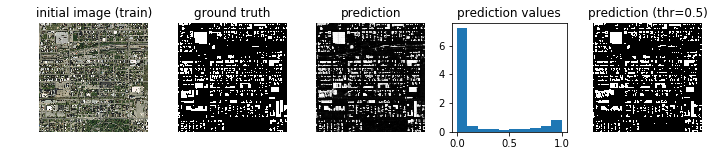

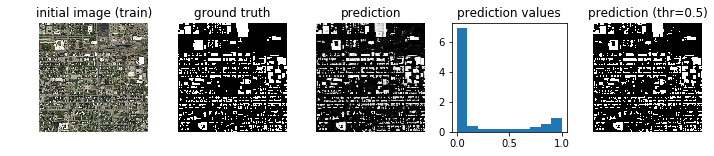

dataset_split: test


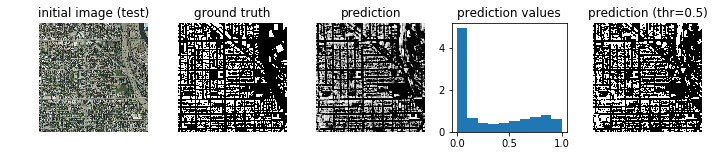

In [15]:
plot_image_mask_prediction(train_images_batch, train_masks_batch, train_preds_batch,
                           dataset_split='train', pred_thr=config.PRED_THR)
plot_image_mask_prediction(test_images_batch, test_masks_batch, test_preds_batch,
                           dataset_split='test', pred_thr=config.PRED_THR)